# Compiling & Visualizing Tracr Models

This notebook demonstrates how to compile a tracr model and provides some tools visualize the model's residual stream or layer outputs for a given input sequence.

In [1]:
import jax
import numpy as np
import matplotlib.pyplot as plt

# The default of float16 can lead to discrepancies between outputs of
# the compiled model and the RASP program.
jax.config.update('jax_default_matmul_precision', 'float32')

from tracr.compiler import compiling
from tracr.compiler import lib
from tracr.rasp import rasp

In [2]:
#@title Plotting functions
def tidy_label(label, value_width=5):
  if ':' in label:
    label, value = label.split(':')
  else:
    value = ''
  return label + f":{value:>{value_width}}"


def add_residual_ticks(model, value_width=5, x=False, y=True):
  if y:
    plt.yticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            fontsize=20,
    )
  if x:
    plt.xticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            rotation=90,
            fontsize=20,
    )


def plot_computation_trace(model,
                           input_labels,
                           residuals_or_outputs,
                           add_input_layer=False,
                           figsize=(12, 9)):
  fig, axes = plt.subplots(nrows=1, ncols=len(residuals_or_outputs), figsize=figsize, sharey=True)
  value_width = max(map(len, map(str, input_labels))) + 1

  for i, (layer, ax) in enumerate(zip(residuals_or_outputs, axes)):
    plt.sca(ax)
    plt.pcolormesh(layer[0].T, vmin=0, vmax=1)
    if i == 0:
      add_residual_ticks(model, value_width=value_width)
    plt.xticks(
        np.arange(len(input_labels))+0.5,
        input_labels,
        rotation=90,
        fontsize=20,
    )
    if add_input_layer and i == 0:
      title = 'Input'
    else:
      layer_no = i - 1 if add_input_layer else i
      layer_type = 'Attn' if layer_no % 2 == 0 else 'MLP'
      title = f'{layer_type} {layer_no // 2 + 1}'
    plt.title(title, fontsize=20)


def plot_residuals_and_input(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the residual stream at each layer."""
  model_out = model.apply(inputs)
  residuals = np.concatenate([model_out.input_embeddings[None, ...],
                              model_out.residuals], axis=0)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=residuals,
      add_input_layer=True,
      figsize=figsize)


def plot_layer_outputs(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the outputs of each layer."""
  model_out = model.apply(inputs)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=model_out.layer_outputs,
      add_input_layer=False,
      figsize=figsize)


In [3]:
#@title Define RASP programs
def get_program(program_name, max_seq_len):
  """Returns RASP program and corresponding token vocabulary."""
  if program_name == "length":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_length()
  elif program_name == "frac_prevs":
    vocab = {"a", "b", "c", "x"}
    program = lib.make_frac_prevs((rasp.tokens == "x").named("is_x"))
  elif program_name == "dyck-2":
    vocab = {"(", ")", "{", "}"}
    program = lib.make_shuffle_dyck(pairs=["()", "{}"])
  elif program_name == "dyck-3":
    vocab = {"(", ")", "{", "}", "[", "]"}
    program = lib.make_shuffle_dyck(pairs=["()", "{}", "[]"])
  elif program_name == "sort":
    vocab = {1, 2, 3, 4, 5}
    program = lib.make_sort(
        rasp.tokens, rasp.tokens, max_seq_len=max_seq_len, min_key=1)
  elif program_name == "sort_unique":
    vocab = {1, 2, 3, 4, 5}
    program = lib.make_sort_unique(rasp.tokens, rasp.tokens)
  elif program_name == "hist":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_hist()
  elif program_name == "sort_freq":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_sort_freq(max_seq_len=max_seq_len)
  elif program_name == "pair_balance":
    vocab = {"(", ")"}
    program = lib.make_pair_balance(
        sop=rasp.tokens, open_token="(", close_token=")")
  else:
    raise NotImplementedError(f"Program {program_name} not implemented.")
  return program, vocab

In [4]:
#@title: Assemble model
program_name = "pair_balance"  #@param ["length", "frac_prevs", "dyck-2", "dyck-3", "sort", "sort_unique", "hist", "sort_freq", "pair_balance"]
max_seq_len = 100  #@param {label: "Test", type: "integer"}

program, vocab = get_program(program_name=program_name,
                             max_seq_len=max_seq_len)

print(f"Compiling...")
print(f"   Program: {program_name}")
print(f"   Input vocabulary: {vocab}")
print(f"   Context size: {max_seq_len}")

assembled_model = compiling.compile_rasp_to_model(
      program=program,
      vocab=vocab,
      max_seq_len=max_seq_len,
      causal=False,
      compiler_bos="bos",
      compiler_pad="pad",
      mlp_exactness=100)

print("Done.")

Compiling...
   Program: pair_balance
   Input vocabulary: {'(', ')'}
   Context size: 100
Done.


In [48]:
type(assembled_model)

tracr.compiler.assemble.AssembledTransformerModel

In [5]:
assembled_model.apply(["bos", "(", "(", ")","(", ")","(", ")", ")", "("]).decoded

['bos',
 0.9925767183303833,
 0.9962745308876038,
 0.3325154185295105,
 0.4990730881690979,
 0.19970926642417908,
 0.33292388916015625,
 0.14271080493927002,
 6.258487701416016e-06,
 0.11102378368377686]

In [63]:
assembled_model.apply(['bos', '(', '(', ')', ')', '(', ')']).decoded

['bos',
 0.9926750063896179,
 0.9963240623474121,
 0.3325154781341553,
 0.0,
 0.19970527291297913,
 0.0]

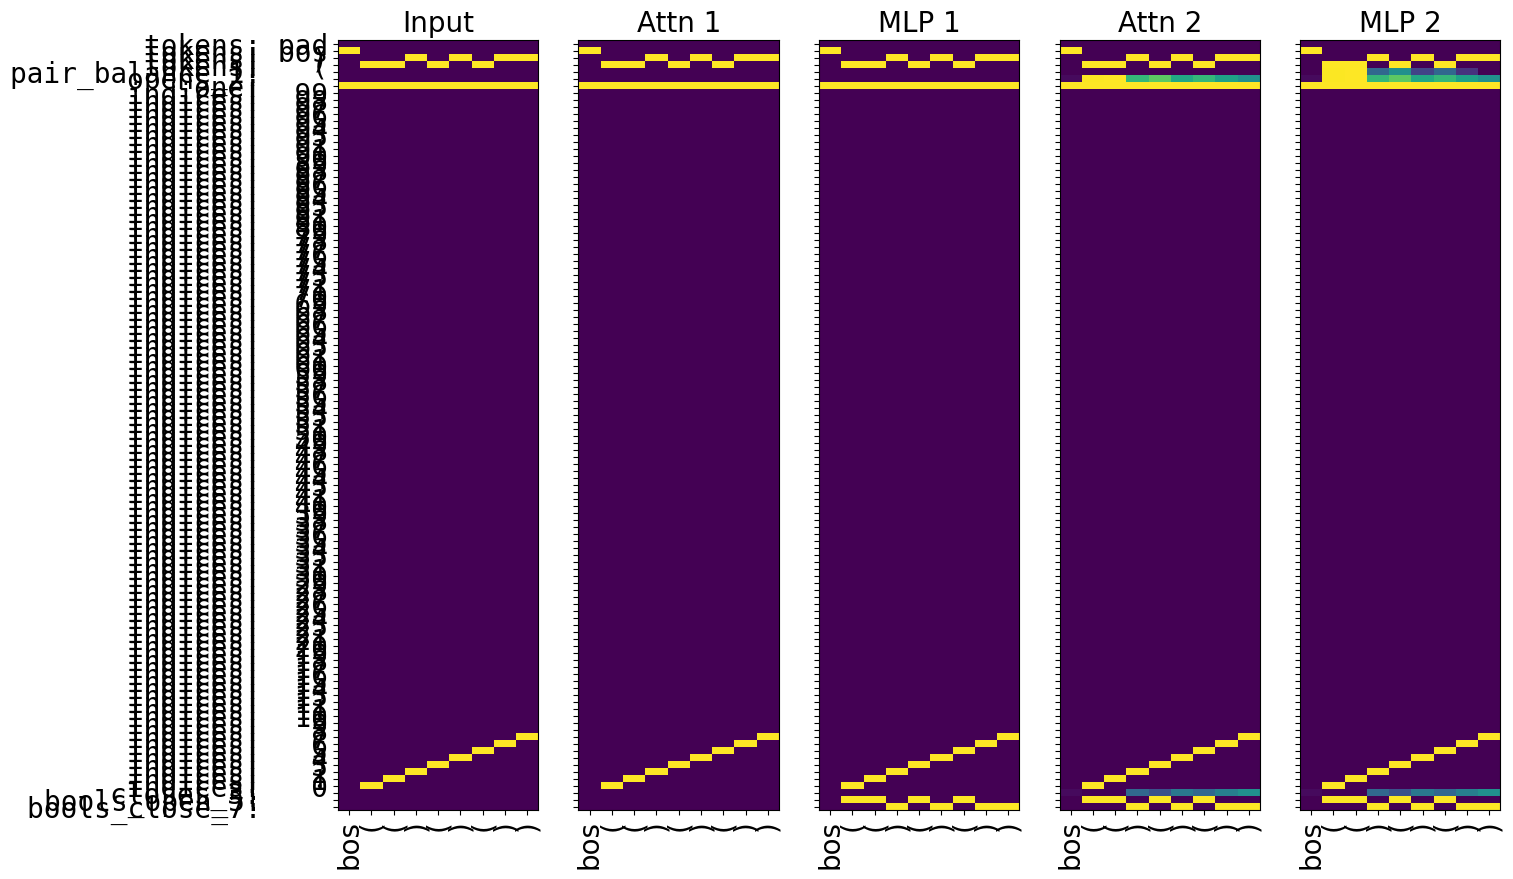

In [7]:
#@title Plot residual stream
plot_residuals_and_input(
  model=assembled_model,
  
  inputs=["bos", "(", "(", ")","(", ")","(", ")", ")"],
  figsize=(15, 10)
)

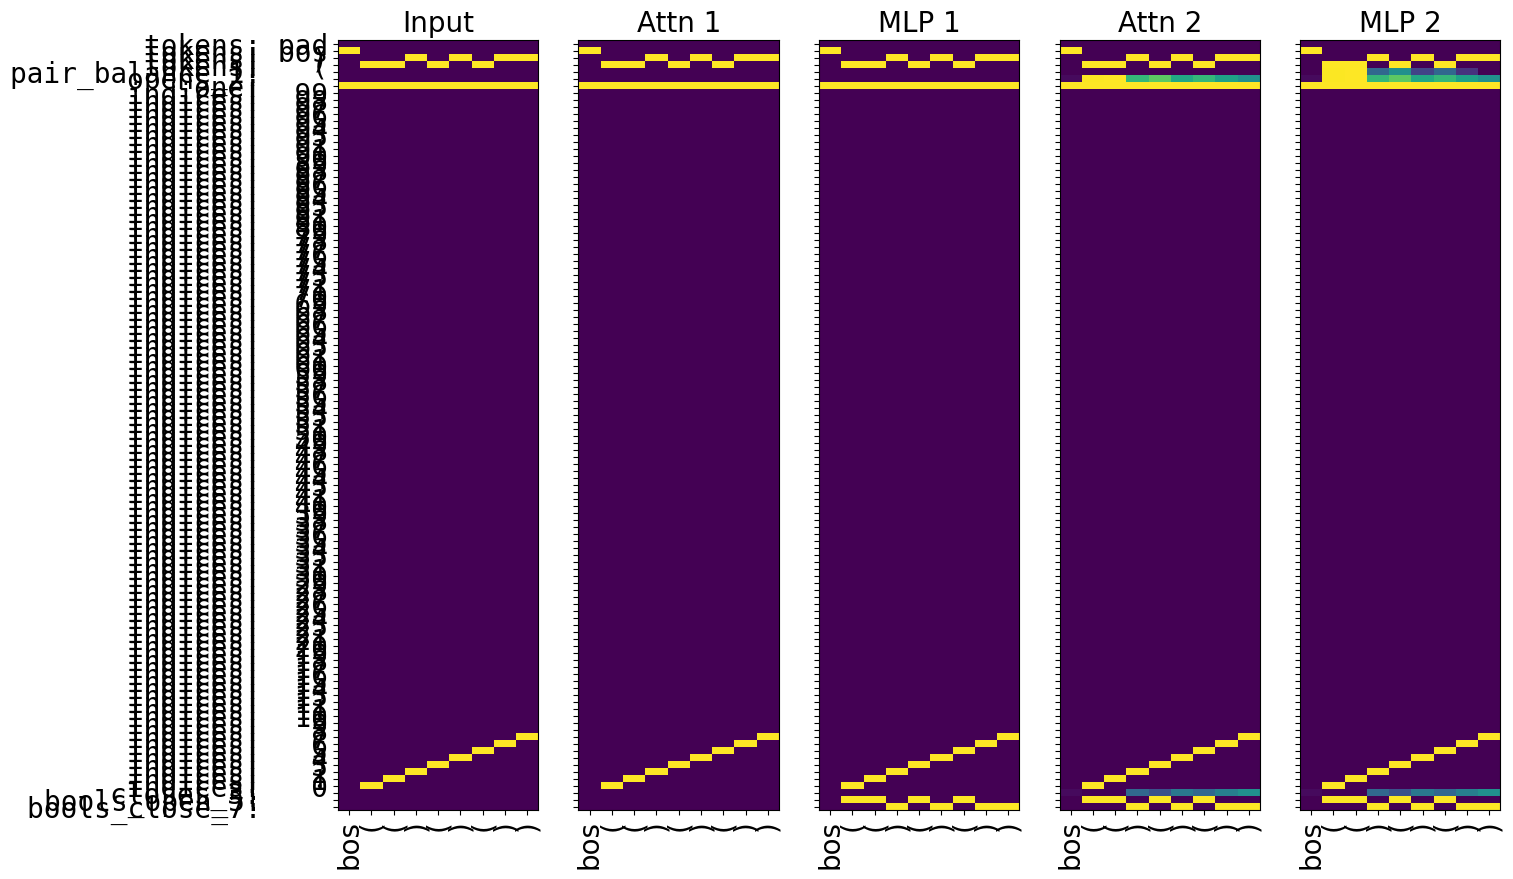

In [8]:
#@title Plot layer outputs
plot_residuals_and_input(
  model=assembled_model,
  inputs = ["bos", "(", "(", ")","(", ")","(", ")", ")"],
  figsize=(15, 10)
)

In [65]:
# balanced = generate_balanced_parentheses(50)
for i in range(1000):
  paren = generate_balanced_parentheses(50)
  if(assembled_model.apply(paren).decoded[-1] != 0):
    print(paren)


In [9]:
import random
import numpy as np
import torch

def generate_balanced_parentheses(max_len=95):
    """
    Generate a random sequence of balanced parentheses.
    
    Args:
        max_len (int): Maximum length of the sequence
    
    Returns:
        list: A list of balanced parentheses tokens
    """
    def is_valid_sequence(sequence):
        """Check if a sequence of parentheses is balanced."""
        stack = []
        for token in sequence:
            if token == '(':
                stack.append(token)
            elif token == ')':
                if not stack:
                    return False
                stack.pop()
        return len(stack) == 0

    while True:
        # Generate a random length
        length = random.randint(2, max_len)
        # Ensure even length for balanced parentheses
        if length % 2 != 0:
            length += 1
        
        # Generate random sequence
        sequence = []
        remaining_open = length // 2
        remaining_close = length // 2
        
        while len(sequence) < length:
            # Decide whether to add an open or close parenthesis
            if remaining_open == 0:
                sequence.append(')')
                remaining_close -= 1
            elif remaining_close == 0:
                sequence.append('(')
                remaining_open -= 1
            else:
                # Probabilistic choice
                choice = random.choice(['(', ')'])
                if choice == '(' and remaining_open > 0:
                    sequence.append('(')
                    remaining_open -= 1
                elif choice == ')' and remaining_close > 0 and len(sequence) > len(sequence) - remaining_close:
                    sequence.append(')')
                    remaining_close -= 1
                else:
                    # Fallback if constraints are not met
                    sequence.append('(')
                    remaining_open -= 1
        
        # Validate the sequence
        if is_valid_sequence(sequence):
            # Prepend BOS token
            return ['bos'] + sequence

def calculate_stack_lengths(sequence):
    """
    Calculate stack lengths for each token position.
    
    Args:
        sequence (list): A sequence of tokens
    
    Returns:
        list: Stack lengths at each token position
    """
    stack_lengths = []
    stack = []
    
    for token in sequence:
        if token == 'bos':
            stack_lengths.append(0)
        elif token == '(':
            stack.append(token)
            stack_lengths.append(len(stack))
        elif token == ')':
            if stack:
                stack.pop()
            stack_lengths.append(len(stack))
    
    return stack_lengths

def generate_dataset(model, num_sequences=5000, max_len=95):
    """
    Generate a dataset of balanced parentheses sequences.
    
    Args:
        model: The compiled model for extracting residuals
        num_sequences (int): Number of sequences to generate
        max_len (int): Maximum length of sequences
    
    Returns:
        tuple: (inputs, labels)
    """
    inputs = []
    labels = []
    
    for _ in range(num_sequences):
        # Generate a balanced parentheses sequence
        sequence = generate_balanced_parentheses(max_len)
        
        # Calculate stack lengths
        stack_lengths = calculate_stack_lengths(sequence)
        
        # Extract residuals from the model
        model_output = model.apply(sequence)
        residuals = model_output.residuals
        
        # Concatenate residuals from all layers (optional)
        # You might want to experiment with different layer combinations
        combined_residuals = np.concatenate(residuals, axis=-1)
        
        # Extract token-level residuals (skip BOS token)
        for i in range(1, len(sequence)):
            inputs.append(combined_residuals[0, i, :])
            labels.append(stack_lengths[i])
    
    return np.array(inputs), np.array(labels)

def generate_control_dataset(model, num_sequences=5000, max_len=95, num_classes=100):
    """
    Generate a control dataset with randomly initialized targets.
    
    Args:
        model: The compiled model for extracting residuals
        num_sequences (int): Number of sequences to generate
        max_len (int): Maximum length of sequences
        num_classes (int): Number of target classes
    
    Returns:
        tuple: (inputs, random labels)
    """
    inputs = []
    labels = []
    
    for _ in range(num_sequences):
        # Generate a balanced parentheses sequence
        sequence = generate_balanced_parentheses(max_len)
        
        # Extract residuals from the model
        model_output = model.apply(sequence)
        residuals = model_output.residuals
        
        # Concatenate residuals from all layers (optional)
        combined_residuals = np.concatenate(residuals, axis=-1)
        
        # Extract token-level residuals (skip BOS token)
        for i in range(1, len(sequence)):
            inputs.append(combined_residuals[0, i, :])
            # Randomly initialize labels independent of input
            labels.append(random.randint(0, num_classes - 1))
    
    return np.array(inputs), np.array(labels)


# Demonstration
if __name__ == "__main__":
    # Create a mock model (replace with your actual model)
    mock_model = assembled_model
    
    # Generate dataset
    # X, y_control = generate_control_dataset(mock_model, num_sequences=1000)
    X, y = generate_dataset(mock_model, num_sequences=1000)
    
    print("Dataset Shape:")
    print(f"Inputs (X): {X.shape}")
    print(f"Labels (y): {y.shape}")
    
    # Optional: Print first few samples
    print("\nFirst few samples:")
    for i in range(min(5, len(X))):
        print(f"Input shape: {X[i].shape}, Stack Length: {y[i]}")

Dataset Shape:
Inputs (X): (37798, 440)
Labels (y): (37798,)

First few samples:
Input shape: (440,), Stack Length: 1
Input shape: (440,), Stack Length: 2
Input shape: (440,), Stack Length: 3
Input shape: (440,), Stack Length: 4
Input shape: (440,), Stack Length: 5


In [56]:
X[0]

array([0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class StackLengthClassifierSimple(nn.Module):
    def __init__(self, input_size):
        """
        Simple linear classifier for stack length prediction
        
        Args:
            input_size (int): Size of input features
        """
        super(StackLengthClassifierSimple, self).__init__()
        self.linear = nn.Linear(input_size, 100)
    
    def forward(self, x):
        x = self.linear(x)
        return x

class StackLengthClassifierSecond(nn.Module):
    def __init__(self, input_size):
        """
        Simple linear classifier for stack length prediction
        
        Args:
            input_size (int): Size of input features
        """
        super(StackLengthClassifierSecond, self).__init__()
        self.linear = nn.Linear(input_size, 16)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(16, 100)
    
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

class StackLengthClassifierThird(nn.Module):
    def __init__(self, input_size):
        """
        Simple linear classifier for stack length prediction
        
        Args:
            input_size (int): Size of input features
        """
        super(StackLengthClassifierThird, self).__init__()
        self.linear = nn.Linear(input_size, 16)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(16, 64)
        self.linear3 = nn.Linear(64, 100)
    
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x

class StackLengthClassifierLast(nn.Module):
    def __init__(self, input_size):
        """
        Simple linear classifier for stack length prediction
        
        Args:
            input_size (int): Size of input features
        """
        super(StackLengthClassifierLast, self).__init__()
        self.linear = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 16)
        self.linear4 = nn.Linear(16, 100)
    
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        return x


def train_and_evaluate(X, y, probe_model, epochs=500):
    """
    Train a linear classifier and evaluate its performance
    
    Args:
        X (np.array): Input features
        y (np.array): Stack length labels
    
    Returns:
        dict: Training history with accuracies
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Instantiate the model
    model = probe_model
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training parameters
    epochs = 500
    batch_size = 32
    
    # Training history
    train_accuracies = []
    test_accuracies = []
    
    # Training loop
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        # Compute training accuracy
        with torch.no_grad():
            train_pred = outputs.argmax(dim=1)
            train_accuracy = (train_pred == y_train_tensor).float().mean().item()
            train_accuracies.append(train_accuracy)
        
        # Compute test accuracy
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_pred = test_outputs.argmax(dim=1)
            test_accuracy = (test_pred == y_test_tensor).float().mean().item()
            test_accuracies.append(test_accuracy)
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(test_accuracies, label='Testing Accuracy')
    plt.title('Model Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return {
        'train_accuracies': train_accuracies, 
        'test_accuracies': test_accuracies
    }


In [11]:
model1 = StackLengthClassifierSimple(input_size=X.shape[1])
model2 = StackLengthClassifierSecond(input_size=X.shape[1])
model3 = StackLengthClassifierThird(input_size=X.shape[1])
model4 = StackLengthClassifierLast(input_size=X.shape[1])

In [ ]:
results = train_and_evaluate(X, y, model1, epochs=10000)
# Print final accuracies
print(f"Final Training Accuracy: {results['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results['test_accuracies'][-1]:.4f}")

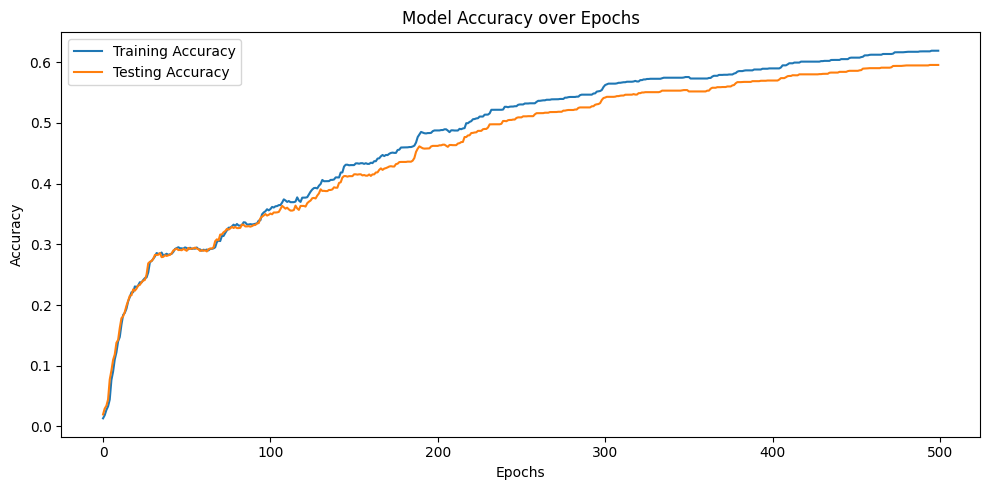

Final Training Accuracy: 0.6190
Final Testing Accuracy: 0.5955


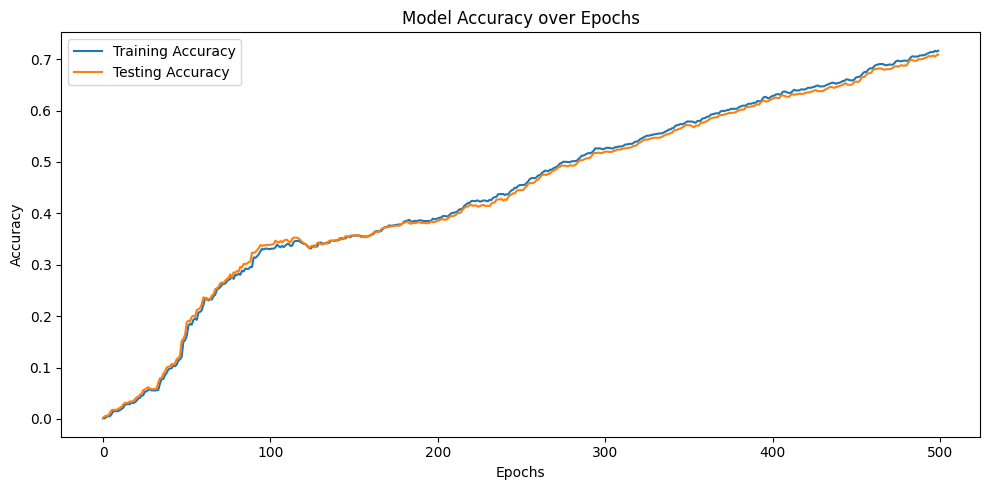

Final Training Accuracy: 0.7164
Final Testing Accuracy: 0.7089


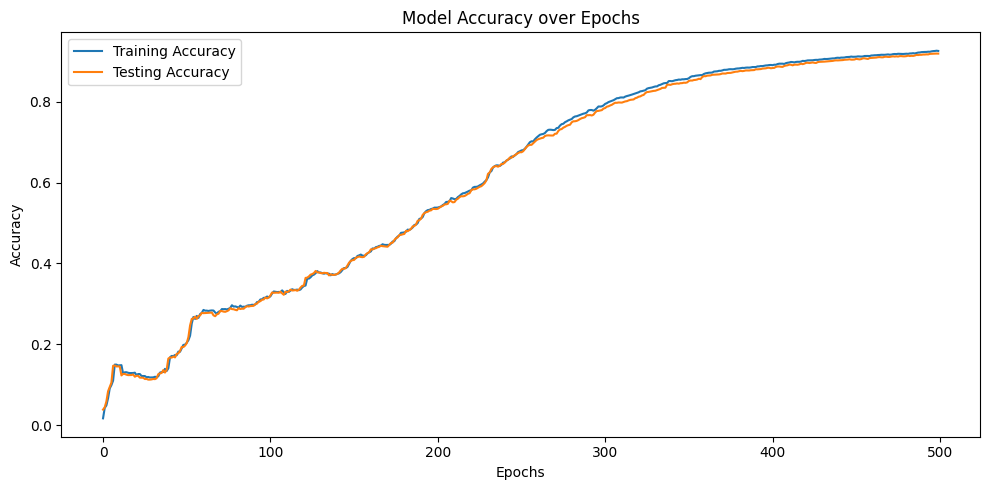

Final Training Accuracy: 0.9258
Final Testing Accuracy: 0.9192


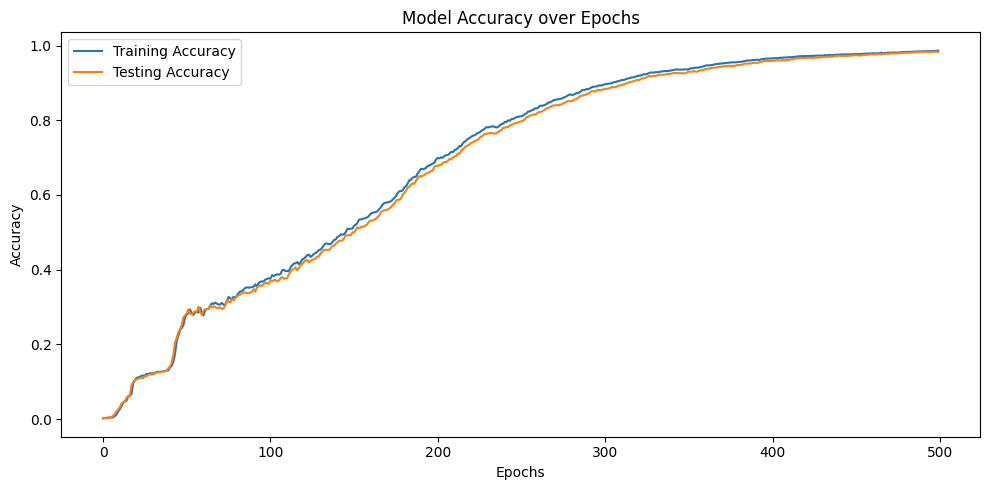

Final Training Accuracy: 0.9864
Final Testing Accuracy: 0.9835


In [12]:
results = train_and_evaluate(X, y, model1, epochs=1000)
# Print final accuracies
print(f"Final Training Accuracy: {results['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results['test_accuracies'][-1]:.4f}")

results2 = train_and_evaluate(X, y, model2, epochs=1000)
# Print final accuracies
print(f"Final Training Accuracy: {results2['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results2['test_accuracies'][-1]:.4f}")

results3 = train_and_evaluate(X, y, model3, epochs=1000)
# Print final accuracies
print(f"Final Training Accuracy: {results3['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results3['test_accuracies'][-1]:.4f}")

results4 = train_and_evaluate(X, y, model4, epochs=1000)
# Print final accuracies
print(f"Final Training Accuracy: {results4['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results4['test_accuracies'][-1]:.4f}")

In [13]:
print(f"Final Training Accuracy: {results['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results['test_accuracies'][-1]:.4f}")

print(f"Final Training Accuracy: {results2['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results2['test_accuracies'][-1]:.4f}")

print(f"Final Training Accuracy: {results3['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results3['test_accuracies'][-1]:.4f}")

print(f"Final Training Accuracy: {results4['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results4['test_accuracies'][-1]:.4f}")

Final Training Accuracy: 0.6190
Final Testing Accuracy: 0.5955
Final Training Accuracy: 0.7164
Final Testing Accuracy: 0.7089
Final Training Accuracy: 0.9258
Final Testing Accuracy: 0.9192
Final Training Accuracy: 0.9864
Final Testing Accuracy: 0.9835


In [24]:
X_control, y_control = generate_control_dataset(mock_model, num_sequences=100)

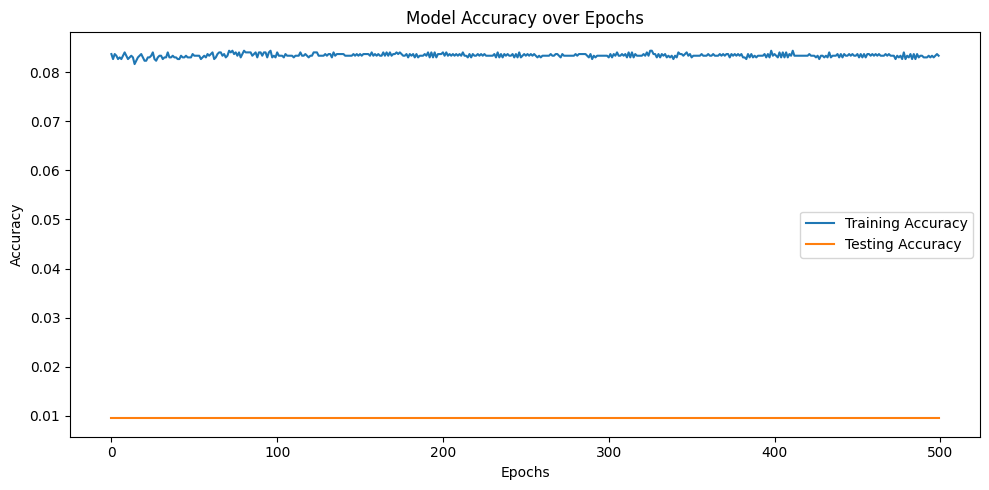

Final Training Accuracy: 0.0833
Final Testing Accuracy: 0.0095


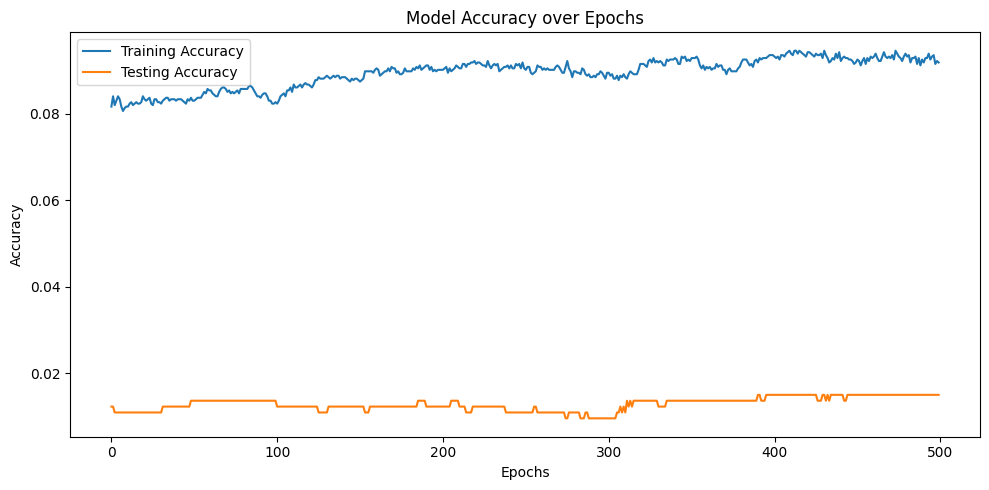

Final Training Accuracy: 0.0918
Final Testing Accuracy: 0.0149


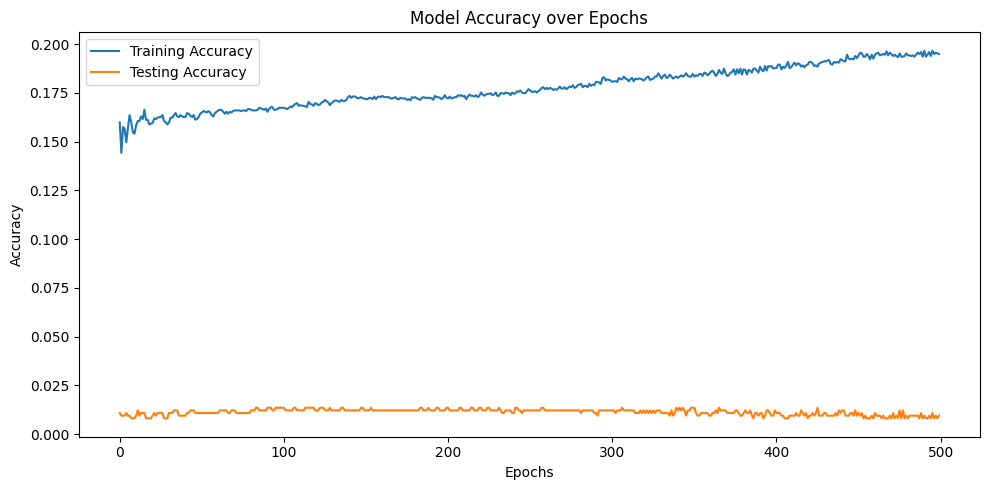

Final Training Accuracy: 0.1949
Final Testing Accuracy: 0.0095


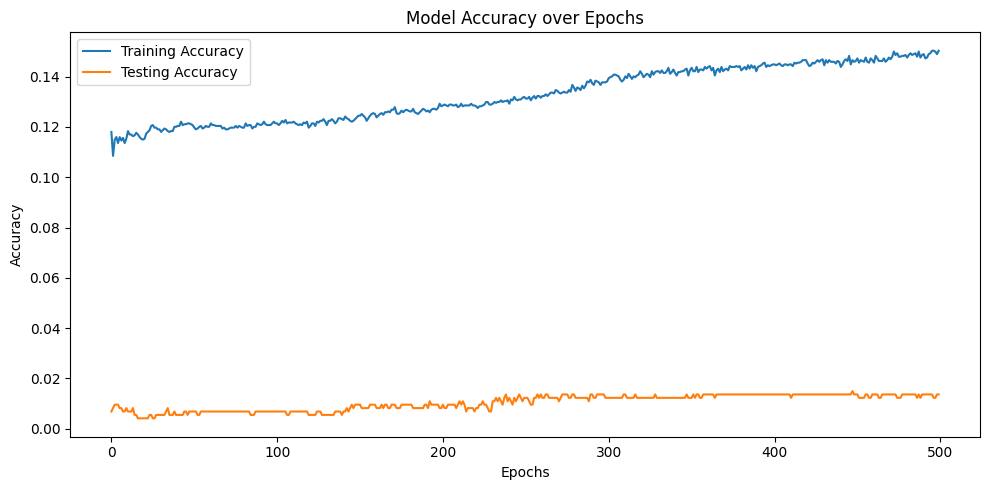

Final Training Accuracy: 0.1503
Final Testing Accuracy: 0.0136


In [30]:
results_control = train_and_evaluate(X_control, y_control, model1, epochs=10000)
# Print final accuracies
print(f"Final Training Accuracy: {results_control['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results_control['test_accuracies'][-1]:.4f}")

results_control2 = train_and_evaluate(X_control, y_control, model2, epochs=1000)
# Print final accuracies
print(f"Final Training Accuracy: {results_control2['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results_control2['test_accuracies'][-1]:.4f}")

results_control3 = train_and_evaluate(X_control, y_control, model3, epochs=1000)
# Print final accuracies
print(f"Final Training Accuracy: {results_control3['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results_control3['test_accuracies'][-1]:.4f}")

results_control4 = train_and_evaluate(X_control, y_control, model4, epochs=1000)
# Print final accuracies
print(f"Final Training Accuracy: {results_control4['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results_control4['test_accuracies'][-1]:.4f}")

In [31]:
print(results_control['train_accuracies'][-1])
print(results_control['test_accuracies'][-1])

print(results_control2['train_accuracies'][-1])
print(results_control2['test_accuracies'][-1])

print(results_control3['train_accuracies'][-1])
print(results_control3['test_accuracies'][-1])

print(results_control4['train_accuracies'][-1])
print(results_control4['test_accuracies'][-1])

0.0833333358168602
0.009510869160294533
0.09183673560619354
0.014945652335882187
0.19489796459674835
0.009510869160294533
0.15034013986587524
0.013586956076323986


In [32]:
task_accs = [results['test_accuracies'][-1], results2['test_accuracies'][-1], results3['test_accuracies'][-1], results4['test_accuracies'][-1]]
control_accs = [results_control['test_accuracies'][-1], results_control2['test_accuracies'][-1], results_control3['test_accuracies'][-1], results_control4['test_accuracies'][-1]]
task_train_accs = [results['train_accuracies'][-1], results2['train_accuracies'][-1], results3['train_accuracies'][-1], results4['train_accuracies'][-1]]
control_train_accs = [results_control['train_accuracies'][-1], results_control2['train_accuracies'][-1], results_control3['train_accuracies'][-1], results_control4['train_accuracies'][-1]]

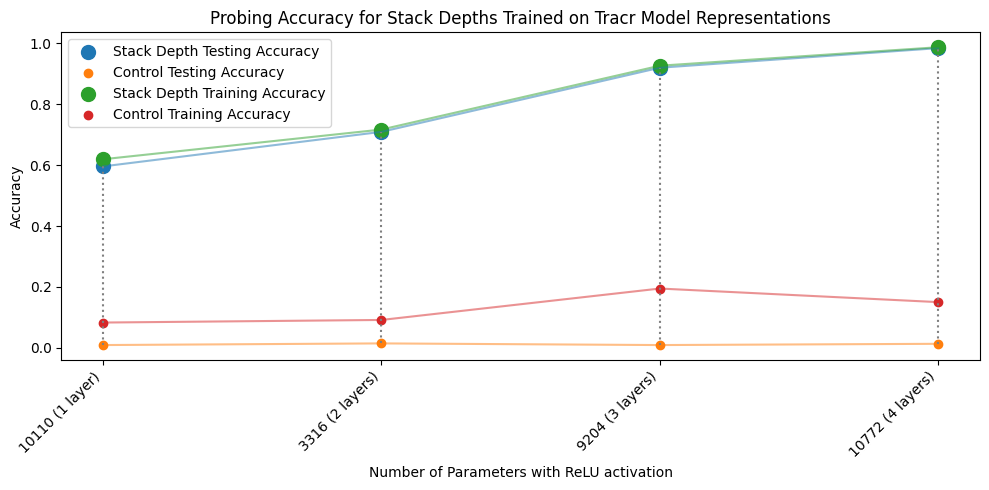

In [45]:
labels = ['10110 (1 layer)', '3316 (2 layers)', '9204 (3 layers)', '10772 (4 layers)']

plt.figure(figsize=(10, 5))
plt.scatter(range(len(task_accs)), task_accs, label='Stack Depth Testing Accuracy', s=100)  # Increase point size
plt.scatter(range(len(control_accs)), control_accs, label='Control Testing Accuracy')
plt.scatter(range(len(task_train_accs)), task_train_accs, label='Stack Depth Training Accuracy', s=100)  # Increase point size
plt.scatter(range(len(control_train_accs)), control_train_accs, label='Control Training Accuracy')

# Add transparent line for task_accs
plt.plot(range(len(task_accs)), task_accs, alpha=0.5)
plt.plot(range(len(control_accs)), control_accs, alpha=0.5)
plt.plot(range(len(task_train_accs)), task_train_accs, alpha=0.5)
plt.plot(range(len(control_train_accs)), control_train_accs, alpha=0.5)

# Add vertical lines between corresponding points
for i in range(len(task_accs)):
    plt.vlines(i, min(task_accs[i], control_accs[i]), max(task_accs[i], control_accs[i]), colors='gray', linestyles='dotted')

plt.title('Probing Accuracy for Stack Depths Trained on Tracr Model Representations')
plt.ylabel('Accuracy')
plt.xlabel('Number of Parameters with ReLU activation')
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Save the figure in high resolution
plt.savefig('high_res_plot_task.png', dpi=300)

plt.show()